# Credit card fraud detection

This project aims at predicts whether a credit card transaction is fraudulent or not using various metrics (unknown for privacy reasons)


In [26]:
# Importing the basics libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from xgboost import Booster
from xgboost import DMatrix

In [2]:
# LOading the data

data = pd.read_csv(r"../input/creditcardfraud/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Checking for unbalanced classes

nf = data[data["Class"] == 0]
f = data[data["Class"] == 1]

print(f"Fraudulent counts: {len(f)}, Non fraudulent counts: {len(nf)}")

print(f"Percentage of fraudulent transactions: {len(f)/len(data)*100: .3f}%")

Fraudulent counts: 492, Non fraudulent counts: 284315
Percentage of fraudulent transactions:  0.173%


From the above out put we can see that there is a huge gap in samples available for each class.

This shows that the majority of the transactions are legal and a very few of them are fradulent.

In [4]:
# Checking for ranges in values for the given features

data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In the above table we can see that most of the features have their means very close to 0 except
`Time` and `Amount`. Their standard deviations are also much greater than the rest of the parameters.

These two features need to be normalized inorder for the model to perform better.

In [5]:
# Converting the `Time` feature into hours of a day using the timestamp feature of python

data["Hour"] = data["Time"].apply(datetime.fromtimestamp).dt.hour


In [6]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,23
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,23
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,23
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,23


Lets compare variation in `Hour` with the two classes

In [7]:
legal_hr_data = pd.DataFrame()
fraud_hr_data = pd.DataFrame()
legal_hr_data["legal"] = data[data["Class"] == 0]["Hour"].describe()
fraud_hr_data["fraud"] = data[data["Class"] == 1]["Hour"].describe()
df = pd.DataFrame([legal_hr_data["legal"], fraud_hr_data["fraud"]])
df

,count,mean,std,min,25%,50%,75%,max
legal,284315.0,14.050623,5.833478,0.0,10.0,15.0,19.0,23.0
fraud,492.0,11.646341,6.663342,0.0,5.0,12.0,17.0,23.0


We can see that there is a lot of difference in the number of sample points.
We can also see that the the fraudulent transactions have a higher standard deviation in the Hour of transaction

Another highly varying parameter is the `Amount` of transaction. Let's do a similar comparision for the Amount feature.

In [8]:
legal_amt_data = pd.DataFrame()
fraud_amt_data = pd.DataFrame()
legal_amt_data["legal"] = data[data["Class"] == 0]["Amount"].describe()
fraud_amt_data["fraud"] = data[data["Class"] == 1]["Amount"].describe()
df = pd.DataFrame([legal_amt_data["legal"], fraud_amt_data["fraud"]])
df

,count,mean,std,min,25%,50%,75%,max
legal,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
fraud,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


From observation we see that the mean transaction amount is higher for fraudulation transactions

## Normalization(Feature engineering)

As the `Hour` and `Amount` columns are also going to be used, they need to be mean centralized.

In [9]:
centred_data = data
centred_data["Amount"] = centred_data["Amount"] - centred_data["Amount"].mean()
centred_data["Hour"] = centred_data["Hour"] - centred_data["Hour"].mean()

centred_data.drop("Time", axis = 1, inplace = True)
# It is no longer needed as the Hour column will be used

In [10]:
centred_data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,2.848070e+05
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,5.926898e-15,0.001727,-7.664093e-16
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,2.501201e+02,0.041527,5.835854e+00
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-8.834962e+01,0.000000,-1.404647e+01
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-8.274962e+01,0.000000,-4.046470e+00
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-6.634962e+01,0.000000,9.535299e-01
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-1.118462e+01,0.000000,4.953530e+00
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,2.560281e+04,1.000000,8.953530e+00


In [11]:
len(data)

284807

In [12]:
dftrain, dftest = train_test_split(data, test_size=0.2, random_state=42, stratify=data[["Class"]])

In [13]:
(len(dftrain[dftrain["Class"] == 1]))

394

In [14]:
# Splitting data into train and test data

dftrain, dftest = train_test_split(data, test_size=0.2, random_state=42, stratify=data[["Class"]])

# Checking for percentage of fraudulent transactions in each split

train_frd = (len(dftrain[dftrain["Class"] == 1]))
print(f"fraudulent percentage in training data {train_frd/(len(dftrain))}")
test_frd = (len(dftest[dftest["Class"] == 1]))
print(f"fraudulent percentage in testing data {test_frd/(len(dftest))}")

fraudulent percentage in training data 0.001729245759178389
fraudulent percentage in testing data 0.0017204452090867595


In [15]:
# Preparing X and y data

X_train = dftrain.drop("Class", axis = 1)
y_train = dftrain["Class"]
X_test = dftest.drop("Class", axis = 1)
y_test = dftest["Class"]

## Adjusting for label imbalance

There are two approaches of dealing with label imbalance,
1. Undersampling: 
2. Oversampling

As undersampling would make the data very small, Oversampling has been chosen. Oversampling is achieved by using **SMOTE**. 

In [17]:
X_train_smote, y_train_smote = SMOTE(random_state=42).fit_resample(X_train, y_train)
smote_value_counts = y_train_smote.value_counts()
print("Fraudulent transactions are %.2f%% of the test set." % (smote_value_counts[0] * 100 / len(y_train_smote)))

Fraudulent transactions are 50.00% of the test set.


Now that the data is ready, let's move on to the modelling part
# Model

The classifier used will be XG boost with optimizing parameters using GridsearchCV

In [18]:
def xgboost_bestparam(X, y, search_verbose=1):
    
    # Typical values for parameters
    params = {
    "gamma":[0.5, 1, 1.5, 2, 5],
    "max_depth":[3,4,5,6],
    "min_child_weight": [100],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.1, 0.01, 0.001]
    }
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)

    grid_search.fit(X, y)

    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

In [19]:
rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 5000)
model_best_params = xgboost_bestparam(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,])

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=100,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 100, 'subsample': 1.0}
Highest AUC: 0.99


In [28]:
xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
xgb.set_params(**model_best_params)
xgb.fit(X_train_smote, y_train_smote, verbose = True)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=100,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

0.9849989376729871


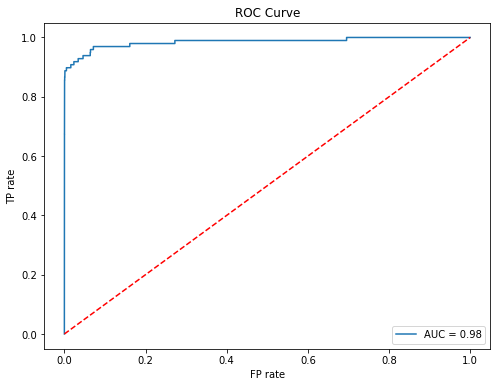

In [30]:
y_pred = xgb.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
print(auc)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()